# Modeling: Statistical

In this notebook, we define some statistical models (unsupervised and supervised versions of the Gaussian HMM) and apply them to the framewise displacement data.

In [1]:
# add modules to path
import sys
sys.path.insert(1, '../src')

# library imports
import torch
import torch.nn as nn
import random
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report

import torch.nn.functional as F
from torch.distributions.normal import Normal

# project imports
import data_processing as dp
import train_eval as te
import models_nn as mnn

# autoreload all modules
%load_ext autoreload
%autoreload 2


In [3]:
RNG_SEED = 42
BATCH_SIZE = 32

np.random.seed(RNG_SEED)

# Load the data from the .npz file
data_dict_ppmi, pd_keys, control_keys = dp.load_ppmi_data()
data_dict_hcp = dp.load_hcp_data()
hcp_keys = list(data_dict_hcp.keys())

# Create balanced dataset: Controls = PD patients
balanced_pd_dataset, info = dp.create_balanced_pd_classification_dataset(
    data_dict_ppmi, pd_keys, control_keys, data_dict_hcp,
    feature_idx=1,  # RMSD
    harmonization_method='quantile_matching',
    balance_strategy='match_pd'  # Total controls = number of PD patients
)

print(f"Dataset size: {len(balanced_pd_dataset)}")
print(f"Balance ratio: {info['balance_ratio']:.1f}:1 (Controls:PD)")

# Train your model
train_loader, val_loader = te.train_val_split(
    balanced_pd_dataset, val_size=0.2, random_state=RNG_SEED, batch_size=BATCH_SIZE
)


Loaded 320/364 PD subjects and 44/88 Control subjects
Loaded 724 run-01 subject combinations
Creating balanced PD classification dataset:
  PPMI PD patients: 320
  PPMI controls: 44
  HCP available: 724
  Strategy: match_pd
  PPMI controls to use: 44
  HCP samples to use: 276
  Total controls: 320
  PD patients: 320
  Final ratio (Controls:PD): 1.0:1
  Harmonizing 276 HCP samples to match PPMI distribution...

Created balanced PD classification dataset:
  Total controls: 320 (PPMI: 44, HCP harmonized: 276)
  Total PD: 320
  Total samples: 640
  Class balance ratio: 1.00:1 (Controls:PD)
  Harmonization method: quantile_matching
Dataset size: 640
Balance ratio: 1.0:1 (Controls:PD)


In [4]:
def get_data_from_loader(loader):
    """Extract data and labels from a DataLoader."""
    data_list = []
    labels_list = []
    for batch in loader:
        data, labels = batch
        data_list.append(data)
        labels_list.append(labels)
    return torch.cat(data_list, dim=0).squeeze().numpy(), torch.cat(labels_list, dim=0).squeeze().numpy()


X_train_raw, y_train = get_data_from_loader(train_loader)
X_val_raw, y_val = get_data_from_loader(val_loader)

X_train = X_train_raw.reshape(X_train_raw.shape[0] * X_train_raw.shape[1], -1)
X_val = X_val_raw.reshape(X_val_raw.shape[0] * X_val_raw.shape[1], -1)
print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_val shape: {X_val.shape}, y_val shape: {y_val.shape}")
lengths_train = np.array([X_train_raw.shape[1]] * X_train_raw.shape[0])
lengths_val = np.array([X_val_raw.shape[1]] * X_val_raw.shape[0])

X = np.concatenate((X_train, X_val), axis=0)
y = np.concatenate((y_train, y_val), axis=0)
lengths = np.concatenate((lengths_train, lengths_val), axis=0)


X_train shape: (102400, 1), y_train shape: (512,)
X_val shape: (25600, 1), y_val shape: (128,)


# Unsupervised Learning

In [5]:
from hmmlearn.hmm import GaussianHMM

RNG_SEED = 42
np.random.seed(RNG_SEED)
n_iter = 10
n_init = 3
results = {}

# Cross-validate HMM with different numbers of components
# (Takes about 15 minutes on a single CPU core)
for n_components in range(2, 7):
    print(f"Training HMM with {n_components} components")
    for i in range(n_init):
        print(f"Initialization {i + 1}/{n_init}")
        ghmm = GaussianHMM(
            n_components=n_components,
            covariance_type='full',
            n_iter=n_iter * n_components,
            random_state=n_components * RNG_SEED + i,
            verbose=True
        )
        ghmm.fit(X, lengths=lengths)
        results[f'{n_components}_init_{i}'] = {
            'model': ghmm,
            'log_likelihoods': ghmm._compute_log_likelihood(X),
            'aic': ghmm.aic(X, lengths=lengths),
            'bic': ghmm.bic(X, lengths=lengths)
        }


Training HMM with 2 components
Initialization 1/3


/opt/anaconda3/lib/python3.9/site-packages/threadpoolctl.py:1214: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
         1 -230578.48524581             +nan
         2 -167563.77723683  +63014.70800898
         3 -164615.00405396   +2948.77318287
         4 -163484.14349318   +1130.86056078
         5 -162782.72553206    +701.41796112
         6 -162241.85854651    +540.86698555
         7 -161798.02451117    +443.83403534
         8 -161429.43804151    +368.58646966
         9 -161123.52387209    +305.91416941
        10 -160870.67741898    +252.84645312
        11 -160662.87

Initialization 2/3


         1 -185701.45329332             +nan
         2 -162318.94186681  +23382.51142652
         3 -161274.36560283   +1044.57626398
         4 -160922.36965515    +351.99594768
         5 -160688.89224508    +233.47741007
         6 -160519.36751121    +169.52473387
         7 -160391.15877150    +128.20873971
         8 -160291.34700128     +99.81177022
         9 -160212.15097304     +79.19602824
        10 -160148.53983573     +63.61113731
        11 -160097.01768019     +51.52215554
        12 -160055.02259411     +41.99508608
        13 -160020.61350101     +34.40909310
        14 -159992.28982857     +28.32367244
        15 -159968.87673971     +23.41308885
        16 -159949.44641359     +19.43032612
        17 -159933.26134647     +16.18506713
        18 -159919.73222501     +13.52912146
        19 -159908.38598699     +11.34623802
        20 -159898.84127227      +9.54471472


Initialization 3/3


         1 -221462.44773335             +nan
         2 -175400.24583956  +46062.20189378
         3 -173813.28917955   +1586.95666002
         4 -173093.15019329    +720.13898625
         5 -172444.16050126    +648.98969203
         6 -171796.43906869    +647.72143257
         7 -171134.18758040    +662.25148829
         8 -170446.43613074    +687.75144966
         9 -169723.04847626    +723.38765448
        10 -168956.00707491    +767.04140135
        11 -168142.06734640    +813.93972850
        12 -167285.96698626    +856.10036014
        13 -166403.09364582    +882.87334045
        14 -165519.74706662    +883.34657919
        15 -164669.20088774    +850.54617888
        16 -163883.82666820    +785.37421954
        17 -163186.75541202    +697.07125617
        18 -162587.59616739    +599.15924464
        19 -162083.82031870    +503.77584868
        20 -161665.53601090    +418.28430780


Training HMM with 3 components
Initialization 1/3


         1 -196699.32118588             +nan
         2 -161939.32046696  +34760.00071892
         3 -159874.14207345   +2065.17839351
         4 -158826.27226520   +1047.86980825
         5 -158203.17860441    +623.09366080
         6 -157786.61721870    +416.56138570
         7 -157477.67439996    +308.94281874
         8 -157226.25598779    +251.41841217
         9 -157004.93572855    +221.32025923
        10 -156798.64795317    +206.28777538
        11 -156600.50913058    +198.13882259
        12 -156410.24662134    +190.26250924
        13 -156232.15266614    +178.09395520
        14 -156071.49579120    +160.65687494
        15 -155931.60919157    +139.88659963
        16 -155813.16560634    +118.44358523
        17 -155714.77649148     +98.38911486
        18 -155633.87023087     +80.90626061
        19 -155567.42770443     +66.44252644
        20 -155512.47046338     +54.95724105
        21 -155466.33092260     +46.13954077
        22 -155426.76840945     +39.56251315
        23

Initialization 2/3


         1 -185962.70049105             +nan
         2 -158240.37448472  +27722.32600632
         3 -156336.07835658   +1904.29612814
         4 -155426.08819367    +909.99016291
         5 -154879.92951653    +546.15867714
         6 -154510.44695481    +369.48256173
         7 -154252.84461368    +257.60234113
         8 -154073.25407973    +179.59053395
         9 -153948.43750644    +124.81657329
        10 -153861.53915491     +86.89835153
        11 -153800.61536360     +60.92379130
        12 -153757.44976800     +43.16559561
        13 -153726.49081554     +30.95895246
        14 -153704.00783681     +22.48297873
        15 -153687.48424527     +16.52359154
        16 -153675.20626692     +12.27797835
        17 -153665.99226501      +9.21400192
        18 -153659.01642243      +6.97584257
        19 -153653.69373762      +5.32268481
        20 -153649.60440670      +4.08933092
        21 -153646.44352120      +3.16088550
        22 -153643.98715917      +2.45636203
        23

Initialization 3/3


         1 -210023.49130671             +nan
         2 -164545.59526736  +45477.89603934
         3 -162915.84647091   +1629.74879645
         4 -162042.31178451    +873.53468640
         5 -161475.78511366    +566.52667085
         6 -161068.07957907    +407.70553459
         7 -160755.63628385    +312.44329522
         8 -160507.39756698    +248.23871687
         9 -160305.90820524    +201.48936174
        10 -160139.95438722    +165.95381802
        11 -160001.78543560    +138.16895162
        12 -159885.77905319    +116.00638241
        13 -159787.67984676     +98.09920643
        14 -159704.14031941     +83.53952736
        15 -159632.44014479     +71.70017462
        16 -159570.31365859     +62.12648620
        17 -159515.84013044     +54.47352814
        18 -159467.36853364     +48.47159680
        19 -159423.46125309     +43.90728056
        20 -159382.84892310     +40.61232998
        21 -159344.39240404     +38.45651906
        22 -159307.04967896     +37.34272508
        23

Training HMM with 4 components
Initialization 1/3


         1 -198018.37979762             +nan
         2 -158526.31930815  +39492.06048948
         3 -157089.25357027   +1437.06573788
         4 -156472.89094538    +616.36262489
         5 -156116.56450098    +356.32644440
         6 -155893.55494962    +223.00955137
         7 -155745.89750275    +147.65744687
         8 -155641.01802096    +104.87948179
         9 -155560.36149992     +80.65652104
        10 -155493.57660202     +66.78489790
        11 -155434.92264813     +58.65395389
        12 -155381.14027087     +53.78237726
        13 -155330.27263870     +50.86763217
        14 -155281.04429237     +49.22834633
        15 -155232.54703873     +48.49725365
        16 -155184.08819506     +48.45884367
        17 -155135.12026439     +48.96793067
        18 -155085.20855936     +49.91170503
        19 -155034.01584861     +51.19271075
        20 -154981.29636569     +52.71948291
        21 -154926.89819651     +54.39816918
        22 -154870.77426819     +56.12392832
        23

Initialization 2/3


         1 -358665.16457469             +nan
         2 -163909.44799469 +194755.71658001
         3 -159544.84063780   +4364.60735688
         4 -157285.03777900   +2259.80285880
         5 -156065.40100426   +1219.63677474
         6 -155406.86781961    +658.53318465
         7 -155003.92273975    +402.94507986
         8 -154714.27906364    +289.64367612
         9 -154484.78151339    +229.49755025
        10 -154298.89525769    +185.88625570
        11 -154150.80213362    +148.09312407
        12 -154035.53142432    +115.27070930
        13 -153947.23663295     +88.29479137
        14 -153880.02681175     +67.20982120
        15 -153828.78687182     +51.23993993
        16 -153789.46828852     +39.31858330
        17 -153759.02644164     +30.44184688
        18 -153735.22613740     +23.80030424
        19 -153716.43788510     +18.78825230
        20 -153701.46996004     +14.96792506
        21 -153689.44321031     +12.02674973
        22 -153679.70192706      +9.74128325
        23

Initialization 3/3


         1 -222379.63152740             +nan
         2 -163423.03270525  +58956.59882214
         3 -161582.71256995   +1840.32013530
         4 -160525.73260779   +1056.97996217
         5 -159818.72666404    +707.00594374
         6 -159321.75848146    +496.96818259
         7 -158972.39543868    +349.36304278
         8 -158729.63032944    +242.76510924
         9 -158561.53028864    +168.10004080
        10 -158443.89776491    +117.63252373
        11 -158359.69275770     +84.20500720
        12 -158297.57213675     +62.12062095
        13 -158250.22761863     +47.34451813
        14 -158212.99383366     +37.23378497
        15 -158182.85252252     +30.14131114
        16 -158157.78935156     +25.06317096
        17 -158136.40738746     +21.38196410
        18 -158117.70870547     +18.69868200
        19 -158100.97988816     +16.72881730
        20 -158085.73693513     +15.24295303
        21 -158071.69580020     +14.04113493
        22 -158058.74139289     +12.95440731
        23

Training HMM with 5 components
Initialization 1/3


         1 -192202.73699123             +nan
         2 -164152.34223704  +28050.39475419
         3 -161533.36118465   +2618.98105240
         4 -159902.93948904   +1630.42169561
         5 -158741.58058914   +1161.35889990
         6 -157873.61415167    +867.96643747
         7 -157219.95625090    +653.65790077
         8 -156729.60270771    +490.35354319
         9 -156358.82352451    +370.77918319
        10 -156070.63627075    +288.18725376
        11 -155835.89867449    +234.73759626
        12 -155631.69468760    +204.20398689
        13 -155442.01410506    +189.68058253
        14 -155260.06452527    +181.94957979
        15 -155085.77211311    +174.29241216
        16 -154920.05621035    +165.71590276
        17 -154762.10229138    +157.95391898
        18 -154610.26864578    +151.83364559
        19 -154463.22369586    +147.04494993
        20 -154320.20540850    +143.01828736
        21 -154180.91834646    +139.28706203
        22 -154045.42041333    +135.49793314
        23

Initialization 2/3


         1 -220771.98972438             +nan
         2 -160253.52164215  +60518.46808223
         3 -158583.97593247   +1669.54570968
         4 -157504.30110877   +1079.67482370
         5 -156766.76499770    +737.53611107
         6 -156222.04929021    +544.71570749
         7 -155785.87870075    +436.17058945
         8 -155420.97969396    +364.89900679
         9 -155108.91389518    +312.06579878
        10 -154837.95366866    +270.96022652
        11 -154599.35301567    +238.60065299
        12 -154386.23873859    +213.11427707
        13 -154193.18426781    +193.05447078
        14 -154015.95399016    +177.23027765
        15 -153851.30169969    +164.65229047
        16 -153696.79931245    +154.50238723
        17 -153550.68815877    +146.11115368
        18 -153411.74743584    +138.94072294
        19 -153279.17583880    +132.57159703
        20 -153152.48435267    +126.69148614
        21 -153031.40025112    +121.08410155
        22 -152915.78381354    +115.61643758
        23

Initialization 3/3


         1 -269826.69937516             +nan
         2 -157706.65274315 +112120.04663201
         3 -156860.89879824    +845.75394491
         4 -156339.03250956    +521.86628868
         5 -155943.66327107    +395.36923848
         6 -155644.92355157    +298.73971950
         7 -155415.19023934    +229.73331223
         8 -155223.63067789    +191.55956145
         9 -155044.87263126    +178.75804663
        10 -154861.42507903    +183.44755223
        11 -154662.04972294    +199.37535609
        12 -154442.22750300    +219.82221994
        13 -154202.56943703    +239.65806597
        14 -153944.25613995    +258.31329708
        15 -153673.36394915    +270.89219080
        16 -153394.97246901    +278.39148013
        17 -153113.78867122    +281.18379779
        18 -152842.11974282    +271.66892841
        19 -152586.91362453    +255.20611828
        20 -152345.56138140    +241.35224313
        21 -152116.13357531    +229.42780610
        22 -151902.68813739    +213.44543792
        23

Training HMM with 6 components
Initialization 1/3


         1 -322741.29389655             +nan
         2 -161451.25383659 +161290.04005996
         3 -159072.05783411   +2379.19600248
         4 -158062.18496276   +1009.87287135
         5 -157429.81904777    +632.36591499
         6 -156963.86064446    +465.95840332
         7 -156590.83461297    +373.02603148
         8 -156283.10312530    +307.73148767
         9 -156028.31018890    +254.79293640
        10 -155817.59693679    +210.71325212
        11 -155641.87986347    +175.71707331
        12 -155491.83740523    +150.04245825
        13 -155359.00412983    +132.83327540
        14 -155236.59905741    +122.40507242
        15 -155119.76104963    +116.83800778
        16 -155005.37972264    +114.38132699
        17 -154891.76660600    +113.61311663
        18 -154778.30461448    +113.46199152
        19 -154665.12367402    +113.18094046
        20 -154552.81348134    +112.31019268
        21 -154442.18039952    +110.63308182
        22 -154334.05933462    +108.12106490
        23

Initialization 2/3


         1 -316092.90860376             +nan
         2 -157953.04696569 +158139.86163808
         3 -154954.11738410   +2998.92958159
         4 -153936.37781737   +1017.73956673
         5 -153478.69097649    +457.68684088
         6 -153194.39971646    +284.29126002
         7 -152975.34374145    +219.05597502
         8 -152787.76622896    +187.57751249
         9 -152618.28537070    +169.48085825
        10 -152459.79985779    +158.48551292
        11 -152307.06716500    +152.73269278
        12 -152155.31528643    +151.75187857
        13 -151999.78604209    +155.52924434
        14 -151835.53066172    +164.25538037
        15 -151657.36732454    +178.16333718
        16 -151460.09949680    +197.26782774
        17 -151239.18003946    +220.91945734
        18 -150992.06494403    +247.11509543
        19 -150720.34217778    +271.72276624
        20 -150431.82734109    +288.51483670
        21 -150140.55640214    +291.27093895
        22 -149863.93265787    +276.62374427
        23

Initialization 3/3


         1 -212664.52114064             +nan
         2 -158167.55404439  +54496.96709625
         3 -156530.41194044   +1637.14210395
         4 -156040.38605424    +490.02588620
         5 -155744.87127387    +295.51478037
         6 -155518.54166754    +226.32960633
         7 -155327.13617871    +191.40548883
         8 -155155.67750500    +171.45867372
         9 -154996.44518033    +159.23232466
        10 -154845.27356462    +151.17161571
        11 -154699.93462923    +145.33893539
        12 -154559.31783250    +140.61679673
        13 -154422.97555759    +136.34227491
        14 -154290.85536546    +132.12019213
        15 -154163.14174113    +127.71362433
        16 -154040.17126120    +122.97047993
        17 -153922.39451630    +117.77674490
        18 -153810.35431518    +112.04020111
        19 -153704.64969297    +105.70462221
        20 -153605.86846429     +98.78122867
        21 -153514.49472614     +91.37373816
        22 -153430.81834615     +83.67637999
        23

In [ ]:
import pickle
from hmmlearn.hmm import GaussianHMM

RNG_SEED = 42
np.random.seed(RNG_SEED)
n_iter = 10
n_init = 3

filename = "results.pkl"

# Load the dictionary
with open(filename, 'rb') as file:
    results = pickle.load(file)


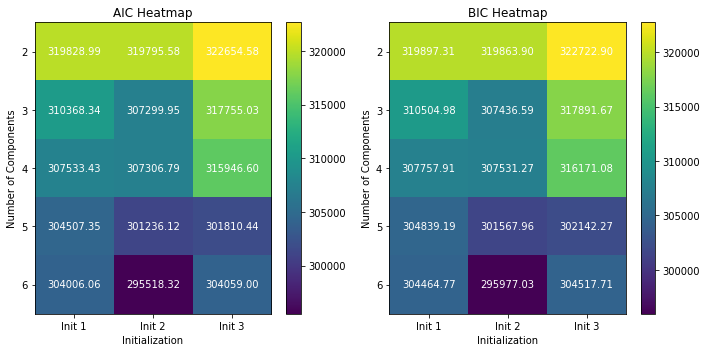

In [9]:
# Generate heatmaps of AIC and BIC
import matplotlib.pyplot as plt
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
n_components_list = list(range(2, 7))
aic = np.array([[results[f'{n}_init_{i}']['aic'] for i in range(n_init)] for n in n_components_list])
bic = np.array([[results[f'{n}_init_{i}']['bic'] for i in range(n_init)] for n in n_components_list])

def plot_heatmap(data, ax, title):
    cax = ax.imshow(data, cmap='viridis', aspect='auto')
    ax.set_xticks(np.arange(n_init))
    ax.set_xticklabels([f'Init {i + 1}' for i in range(n_init)])
    ax.set_yticks(np.arange(len(n_components_list)))
    ax.set_yticklabels(n_components_list)
    ax.set_title(title)
    ax.set_xlabel('Initialization')
    ax.set_ylabel('Number of Components')
    # Annotate each cell with the value
    for i in range(data.shape[0]):
        for j in range(data.shape[1]):
            ax.text(j, i, f'{data[i, j]:.2f}', ha='center', va='center', color='white')
    plt.colorbar(cax, ax=ax)

plot_heatmap(aic, axs[0], 'AIC Heatmap')
plot_heatmap(bic, axs[1], 'BIC Heatmap')
plt.tight_layout()
plt.show()


In [ ]:
import pickle

#my_dict = {"key1": "value1", "key2": 2, "key3": [1, 2, 3]}
filename = "results.pkl"

# Save the dictionary
with open(filename, 'wb') as file:
    pickle.dump(results, file)


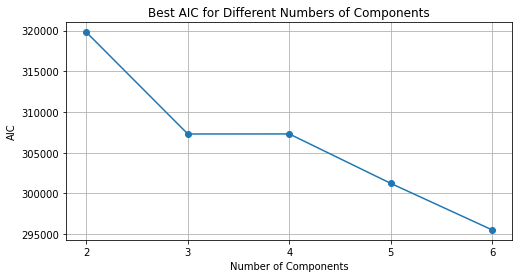

In [ ]:
plt.plot(aic.min(axis=1), 'o-', label='AIC Min per Components')
#plt.plot(bic.min(axis=1), label='BIC Min per Components')
plt.xticks(range(len(n_components_list)), n_components_list)
plt.xlabel('Number of Components')
plt.ylabel('AIC')
plt.title('Best AIC for Different Numbers of Components')
#plt.legend()
plt.gcf().set_size_inches(8, 4)
plt.grid()
plt.savefig('../outputs/best_aic_per_components.png', dpi=300)
plt.show()


In [14]:
results['3_init_1']['model']


GaussianHMM(covariance_type='full', n_components=3, n_iter=30, random_state=127,
            verbose=True)

In [11]:
# Best model: 5 components, 3rd initialization
# covariance_type='full', n_components=5, n_iter=50, random_state=212
# Selected based on lowest AIC/BIC and elbow method
#best_model = results['5_init_2']['model']
best_model = GaussianHMM(
    covariance_type='full', n_components=3, n_iter=100, random_state=127,
    verbose=True
)
best_model.fit(X, lengths=lengths)
best_model


/opt/anaconda3/lib/python3.9/site-packages/threadpoolctl.py:1214: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
         1 -185683.76337194             +nan
         2 -158134.41192699  +27549.35144495
         3 -156397.83445578   +1736.57747121
         4 -155437.05736743    +960.77708836
         5 -154799.69323062    +637.36413680
         6 -154352.99443811    +446.69879251
         7 -154052.57442373    +300.42001438
         8 -153858.58207882    +193.99234491
         9 -153735.48222167    +123.09985714
        10 -153657.55522773     +77.92699394
        11 -153607.80

GaussianHMM(covariance_type='full', n_components=3, n_iter=100,
            random_state=127, verbose=True)

## Best Model Analysis

/var/folders/gn/n4hz1bh52t190f6wd1mfjtzr0000gn/T/ipykernel_8326/298065850.py:41: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend(loc='upper right')
/var/folders/gn/n4hz1bh52t190f6wd1mfjtzr0000gn/T/ipykernel_8326/298065850.py:68: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend(loc='upper right')


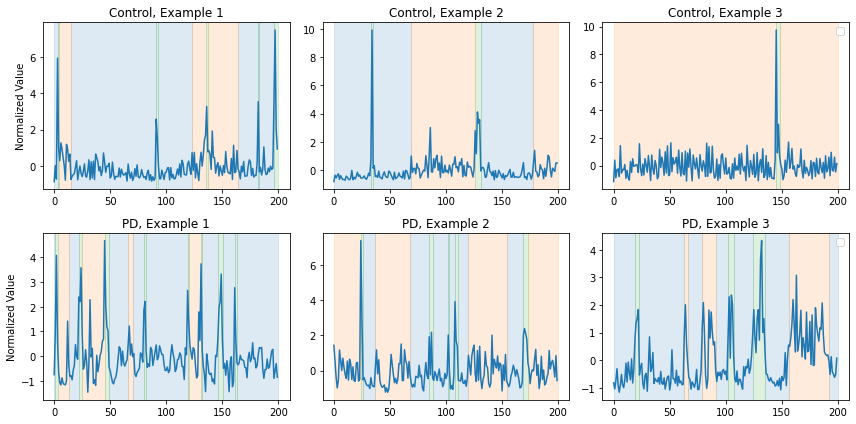

In [ ]:
import numpy as np

import matplotlib.pyplot as plt

# Helper to get start/end indices for each sequence in X
seq_starts = np.cumsum([0] + list(lengths[:-1]))
seq_ends = np.cumsum(lengths)

# Find indices for three control and three PD subjects
# Controls: y == 0, PD: y == 1
control_indices = np.where(y == 0)[0][:3]
pd_indices = np.where(y == 1)[0][:3]

fig, axs = plt.subplots(2, 3, figsize=(18, 8), sharex=False)

for col, idx in enumerate(control_indices):
    ax = axs[0, col]
    start, end = seq_starts[idx], seq_ends[idx]
    sample = X[start:end]
    t = np.arange(len(sample))
    states = best_model.predict(sample)
    ax.plot(t, sample)
    # Shade regions by state
    for s in np.unique(states):
        mask = states == s
        in_region = False
        region_start = None
        for i, m in enumerate(mask):
            if m and not in_region:
                region_start = i
                in_region = True
            elif not m and in_region:
                ax.axvspan(region_start, i, color=f"C{s}", alpha=0.15)
                in_region = False
        if in_region:
            ax.axvspan(region_start, len(mask), color=f"C{s}", alpha=0.15)
    ax.set_title(f"Control, Example {col+1}")
    if col == 0:
        ax.set_ylabel("Normalized Value")
    if col == 2:
        ax.legend(loc='upper right')

for col, idx in enumerate(pd_indices):
    ax = axs[1, col]
    start, end = seq_starts[idx], seq_ends[idx]
    sample = X[start:end]
    t = np.arange(len(sample))
    states = best_model.predict(sample)
    ax.plot(t, sample)
    # Shade regions by state
    for s in np.unique(states):
        mask = states == s
        in_region = False
        region_start = None
        for i, m in enumerate(mask):
            if m and not in_region:
                region_start = i
                in_region = True
            elif not m and in_region:
                ax.axvspan(region_start, i, color=f"C{s}", alpha=0.15)
                in_region = False
        if in_region:
            ax.axvspan(region_start, len(mask), color=f"C{s}", alpha=0.15)
    ax.set_title(f"PD, Example {col+1}")
    if col == 0:
        ax.set_ylabel("Normalized Value")
    if col == 2:
        ax.legend(loc='upper right')

plt.gcf().set_size_inches(12, 6)
plt.tight_layout()
plt.savefig('../outputs/hmm_states_example.png', dpi=300)
plt.show()


In [13]:
import pandas as pd

## Get the best model (assuming you want the best by AIC/BIC, e.g. 3_init_1)
#best_model = results['3_init_1']['model']

# Predict hidden states for the entire dataset
states = best_model.predict(X, lengths)

n_states = best_model.n_components

# Compute mean and variance for each state
means = []
vars_ = []
for s in range(n_states):
    mask = states == s
    means.append(X[mask].mean())
    vars_.append(X[mask].var())

means = np.array(means)
vars_ = np.array(vars_)

# Compute per-sample state proportions
def compute_state_proportions(model, X, lengths):
    states = model.predict(X, lengths=lengths)
    n_states = model.n_components
    n_samples = len(lengths)
    proportions = np.zeros((n_samples, n_states))
    seq_starts = np.cumsum([0] + list(lengths[:-1]))
    seq_ends = np.cumsum(lengths)
    for i, (st, en) in enumerate(zip(seq_starts, seq_ends)):
        sample_states = states[st:en]
        for s in range(n_states):
            proportions[i, s] = np.mean(sample_states == s)
    return proportions

# Use X, lengths, y from previous cells
proportions = compute_state_proportions(best_model, X, lengths)

# For all subjects, use X, lengths, y
proportions_all = compute_state_proportions(best_model, X, lengths)
y = y.astype(int)
control_idx = np.where(y == 0)[0]
pd_idx = np.where(y == 1)[0]

rows = []
for s in range(n_states):
    # Mean and variance for this state
    mean = means[s]
    var = vars_[s]
    # Proportion of total time spent in this state for each group
    prop_ctrl = proportions_all[control_idx, s].sum() / len(control_idx)
    prop_pd = proportions_all[pd_idx, s].sum() / len(pd_idx)
    # Percentiles for each group
    pct_ctrl = np.percentile(proportions_all[control_idx, s], [5, 50, 95])
    pct_pd = np.percentile(proportions_all[pd_idx, s], [5, 50, 95])
    rows.append({
        "State": s,
        "Mean": mean,
        "Variance": var,
        "Prop_Total_Control": prop_ctrl,
        "Prop_Total_PD": prop_pd,
        "Control_5th": pct_ctrl[0],
        "Control_50th": pct_ctrl[1],
        "Control_95th": pct_ctrl[2],
        "PD_5th": pct_pd[0],
        "PD_50th": pct_pd[1],
        "PD_95th": pct_pd[2],
    })

df_states = pd.DataFrame(rows)
pd.set_option('display.precision', 4)
display(df_states)


,State,Mean,Variance,Prop_Total_Control,Prop_Total_PD,Control_5th,Control_50th,Control_95th,PD_5th,PD_50th,PD_95th
0,0,-0.4013,0.1650,0.2921,0.4291,0.000,0.220,0.804,0.0000,0.455,0.845
1,1,0.0725,0.8129,0.6770,0.5233,0.134,0.750,1.000,0.1025,0.490,0.990
2,2,2.5866,3.2373,0.0309,0.0476,0.000,0.025,0.085,0.0050,0.045,0.100


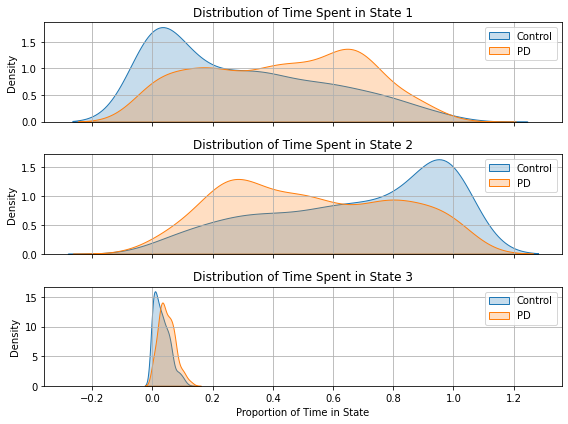

In [ ]:
import seaborn as sns

import matplotlib.pyplot as plt

fig, axs = plt.subplots(3, 1, figsize=(8, 12), sharex=True)

for i in range(3):
    ctrl_props = proportions_all[y == 0, i]
    pd_props = proportions_all[y == 1, i]
    ax = axs[i]
    sns.kdeplot(ctrl_props, ax=ax, label='Control', fill=True, color='C0')
    sns.kdeplot(pd_props, ax=ax, label='PD', fill=True, color='C1')
    ax.set_title(f"Distribution of Time Spent in State {i + 1}")
    ax.set_ylabel("Density")
    ax.grid(True)
    ax.legend()

axs[-1].set_xlabel("Proportion of Time in State")
plt.gcf().set_size_inches(8, 6)
plt.tight_layout()
plt.savefig('../outputs/state_proportions_distribution.png', dpi=300)
plt.show()


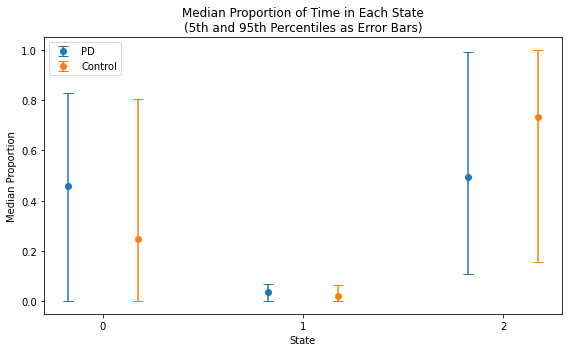

In [20]:
# Boxplot of medians for PD and CtrlHCP with 5th and 95th percentiles as error bars

fig, ax = plt.subplots(figsize=(8, 5))

# Extract medians and error bars from df_states
pd_medians = df_states["PD_50th"]
ctrlhcp_medians = df_states["Control_50th"]

pd_err = np.vstack([
    pd_medians - df_states["PD_5th"],
    df_states["PD_95th"] - pd_medians
])
ctrlhcp_err = np.vstack([
    ctrlhcp_medians - df_states["Control_5th"],
    df_states["Control_95th"] - ctrlhcp_medians
])

positions = np.arange(len(df_states))
width = 0.35

ax.errorbar(
    positions - width/2, pd_medians, yerr=pd_err, fmt='o', label='PD', capsize=5
)
ax.errorbar(
    positions + width/2, ctrlhcp_medians, yerr=ctrlhcp_err, fmt='o', label='Control', capsize=5
)

ax.set_xticks(positions)
ax.set_xticklabels(df_states["State"])
ax.set_xlabel("State")
ax.set_ylabel("Median Proportion")
ax.set_title("Median Proportion of Time in Each State\n(5th and 95th Percentiles as Error Bars)")
ax.legend()
plt.tight_layout()
plt.show()


# Supervised Learning

In [ ]:
RNG_SEED = 42
BATCH_SIZE = 32

np.random.seed(RNG_SEED)

# Load the data from the .npz file
data_dict_ppmi, pd_keys, control_keys = dp.load_ppmi_data()
data_dict_hcp = dp.load_hcp_data()
hcp_keys = list(data_dict_hcp.keys())

# Create balanced dataset: Controls = PD patients
balanced_pd_dataset, info = dp.create_balanced_pd_classification_dataset(
    data_dict_ppmi, pd_keys, control_keys, data_dict_hcp,
    feature_idx=1,  # RMSD
    harmonization_method='quantile_matching',
    balance_strategy='match_pd'  # Total controls = number of PD patients
)

print(f"Dataset size: {len(balanced_pd_dataset)}")
print(f"Balance ratio: {info['balance_ratio']:.1f}:1 (Controls:PD)")

# Train your model
train_loader, val_loader = te.train_val_split(
    balanced_pd_dataset, val_size=0.2, random_state=RNG_SEED, batch_size=BATCH_SIZE
)


Loaded 320/364 PD subjects and 44/88 Control subjects
Loaded 724 run-01 subject combinations
Creating balanced PD classification dataset:
  PPMI PD patients: 320
  PPMI controls: 44
  HCP available: 724
  Strategy: match_pd
  PPMI controls to use: 44
  HCP samples to use: 276
  Total controls: 320
  PD patients: 320
  Final ratio (Controls:PD): 1.0:1
  Harmonizing 276 HCP samples to match PPMI distribution...

Created balanced PD classification dataset:
  Total controls: 320 (PPMI: 44, HCP harmonized: 276)
  Total PD: 320
  Total samples: 640
  Class balance ratio: 1.00:1 (Controls:PD)
  Harmonization method: quantile_matching
Dataset size: 640
Balance ratio: 1.0:1 (Controls:PD)


In [ ]:
def get_data_from_loader(loader):
    """Extract data and labels from a DataLoader."""
    data_list = []
    labels_list = []
    for batch in loader:
        data, labels = batch
        data_list.append(data)
        labels_list.append(labels)
    return torch.cat(data_list, dim=0).squeeze().numpy(), torch.cat(labels_list, dim=0).squeeze().numpy()


X_train_raw, y_train = get_data_from_loader(train_loader)
X_val_raw, y_val = get_data_from_loader(val_loader)

X_train = X_train_raw.reshape(X_train_raw.shape[0] * X_train_raw.shape[1], -1)
X_val = X_val_raw.reshape(X_val_raw.shape[0] * X_val_raw.shape[1], -1)
print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_val shape: {X_val.shape}, y_val shape: {y_val.shape}")
lengths_train = np.array([X_train_raw.shape[1]] * X_train_raw.shape[0])
lengths_val = np.array([X_val_raw.shape[1]] * X_val_raw.shape[0])

X = np.concatenate((X_train, X_val), axis=0)
y = np.concatenate((y_train, y_val), axis=0)
lengths = np.concatenate((lengths_train, lengths_val), axis=0)


X_train shape: (102400, 1), y_train shape: (512,)
X_val shape: (25600, 1), y_val shape: (128,)


In [ ]:
from hmmlearn.hmm import GaussianHMM

RNG_SEED = 42
np.random.seed(RNG_SEED)
n_iter = 10
n_init = 3
results = {}

for n_components in range(2, 7):
    print(f"Training HMM with {n_components} components")
    for i in range(n_init):
        print(f"Initialization {i + 1}/{n_init}")
        ghmm = GaussianHMM(
            n_components=n_components,
            covariance_type='full',
            n_iter=n_iter * n_components,
            random_state=n_components * RNG_SEED + i,
            verbose=True
        )
        ghmm.fit(X_train, lengths=lengths_train)

        results[f'{n_components}_init_{i}'] = {
            'model': ghmm,
            'log_likelihoods': ghmm._compute_log_likelihood(X_train),
            'aic': ghmm.aic(X_train, lengths=lengths_train),
            'bic': ghmm.bic(X_train, lengths=lengths_train)
        }


Training HMM with 2 components
Initialization 1/3


/opt/anaconda3/lib/python3.9/site-packages/threadpoolctl.py:1214: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
         1 -186916.34804795             +nan
         2 -132719.27646176  +54197.07158619
         3 -130110.40320160   +2608.87326017
         4 -129112.24123651    +998.16196509
         5 -128517.83512173    +594.40611478
         6 -128080.18879353    +437.64632820
         7 -127737.24120078    +342.94759275
         8 -127465.70660629    +271.53459449
         9 -127251.31931926    +214.38728702
        10 -127083.03909788    +168.28022138
        11 -126951.78

Initialization 2/3


         1 -148474.84643066             +nan
         2 -128499.93090155  +19974.91552911
         3 -127663.06084478    +836.87005677
         4 -127377.96345058    +285.09739420
         5 -127193.16993250    +184.79351808
         6 -127060.84415357    +132.32577893
         7 -126961.09363311     +99.75052046
         8 -126883.22538136     +77.86825174
         9 -126821.06347342     +62.16190794
        10 -126770.72229199     +50.34118143
        11 -126729.55720330     +41.16508869
        12 -126695.66233811     +33.89486519
        13 -126667.61069970     +28.05163841
        14 -126644.30549729     +23.30520241
        15 -126624.88741689     +19.41808040
        16 -126608.67308608     +16.21433080
        17 -126595.11247764     +13.56060845
        18 -126583.75852046     +11.35395718
        19 -126574.24490393      +9.51361653
        20 -126566.26953955      +7.97536438


Initialization 3/3


         1 -180295.19110487             +nan
         2 -139754.00575856  +40541.18534630
         3 -138356.67826817   +1397.32749039
         4 -137678.33368835    +678.34457982
         5 -137062.14665075    +616.18703760
         6 -136446.97974248    +615.16690827
         7 -135813.82390680    +633.15583568
         8 -135147.99165056    +665.83225624
         9 -134437.38659727    +710.60505330
        10 -133675.13980190    +762.24679537
        11 -132863.76273757    +811.37706433
        12 -132019.27395032    +844.48878725
        13 -131172.35670072    +846.91724960
        14 -130363.24517648    +809.11152424
        15 -129630.39026332    +732.85491316
        16 -128998.79053273    +631.59973060
        17 -128475.35865378    +523.43187895
        18 -128052.70156464    +422.65708914
        19 -127716.40354954    +336.29801510
        20 -127450.83296116    +265.57058838


Training HMM with 3 components
Initialization 1/3


         1 -221248.54987446             +nan
         2 -130252.70190097  +90995.84797349
         3 -128153.21756235   +2099.48433862
         4 -126899.87824846   +1253.33931389
         5 -125973.66300784    +926.21524062
         6 -125274.58527228    +699.07773556
         7 -124745.80756491    +528.77770737
         8 -124342.48648560    +403.32107931
         9 -124028.66076999    +313.82571561
        10 -123776.57417564    +252.08659435
        11 -123565.61734132    +210.95683432
        12 -123381.13389176    +184.48344956
        13 -123213.63564542    +167.49824635
        14 -123058.37738281    +155.25826260
        15 -122914.20713429    +144.17024853
        16 -122781.25949664    +132.94763765
        17 -122659.16542421    +122.09407243
        18 -122546.91292701    +112.25249719
        19 -122443.41037278    +103.50255424
        20 -122347.80782762     +95.60254515
        21 -122259.52364624     +88.28418138
        22 -122178.17137480     +81.35227144
        23

Initialization 2/3


         1 -149500.28414387             +nan
         2 -124751.62745223  +24748.65669164
         3 -123405.58084386   +1346.04660837
         4 -122773.67951842    +631.90132544
         5 -122365.12065774    +408.55886068
         6 -122086.04776901    +279.07288873
         7 -121896.43408641    +189.61368260
         8 -121768.70623868    +127.72784773
         9 -121682.17906952     +86.52716916
        10 -121622.52244303     +59.65662650
        11 -121580.45576552     +42.06667751
        12 -121550.11005368     +30.34571183
        13 -121527.74639214     +22.36366154
        14 -121510.93027774     +16.81611441
        15 -121498.04116937     +12.88910837
        16 -121487.98158699     +10.05958238
        17 -121479.99761551      +7.98397148
        18 -121473.56405739      +6.43355812
        19 -121468.30949108      +5.25456631
        20 -121463.96692143      +4.34256965
        21 -121460.34109476      +3.62582668
        22 -121457.28671702      +3.05437774
        23

Initialization 3/3


         1 -148479.16344910             +nan
         2 -126367.55456660  +22111.60888250
         3 -125227.08058187   +1140.47398474
         4 -124476.25287520    +750.82770667
         5 -123866.27119501    +609.98168019
         6 -123356.86109007    +509.41010494
         7 -122929.53079693    +427.33029314
         8 -122569.14544497    +360.38535196
         9 -122270.78804059    +298.35740437
        10 -122034.23211939    +236.55592120
        11 -121855.69981077    +178.53230862
        12 -121726.93720690    +128.76260387
        13 -121637.48378138     +89.45342552
        14 -121577.09692276     +60.38685863
        15 -121537.09694689     +39.99997586
        16 -121510.79618390     +26.30076299
        17 -121493.41249271     +17.38369119
        18 -121481.72100445     +11.69148826
        19 -121473.63475310      +8.08625135
        20 -121467.83748371      +5.79726939
        21 -121463.51071182      +4.32677189
        22 -121460.14832563      +3.36238618
        23

Training HMM with 4 components
Initialization 1/3


         1 -152719.15271398             +nan
         2 -128131.34509801  +24587.80761597
         3 -126214.88542078   +1916.45967723
         4 -125252.03636699    +962.84905380
         5 -124597.96044540    +654.07592159
         6 -124127.11928492    +470.84116048
         7 -123795.92853920    +331.19074572
         8 -123571.92788491    +224.00065429
         9 -123422.66241354    +149.26547137
        10 -123319.55377745    +103.10863609
        11 -123241.37578775     +78.17798970
        12 -123173.40031282     +67.97547494
        13 -123103.70104996     +69.69926285
        14 -123017.97003056     +85.73101941
        15 -122893.88466669    +124.08536386
        16 -122706.79988126    +187.08478543
        17 -122475.54633509    +231.25354617
        18 -122281.49891649    +194.04741860
        19 -122163.25811443    +118.24080207
        20 -122094.28796960     +68.97014483
        21 -122048.02523558     +46.26273402
        22 -122012.62087966     +35.40435592
        23

Initialization 2/3


         1 -221021.04986857             +nan
         2 -127904.69692054  +93116.35294802
         3 -126701.01859281   +1203.67832773
         4 -126011.54183764    +689.47675517
         5 -125531.63521958    +479.90661806
         6 -125181.94596635    +349.68925323
         7 -124914.56779188    +267.37817447
         8 -124697.88624242    +216.68154946
         9 -124512.77851552    +185.10772690
        10 -124348.60139224    +164.17712328
        11 -124199.71129165    +148.89010059
        12 -124063.13596286    +136.57532879
        13 -123937.19627209    +125.93969077
        14 -123820.72175877    +116.47451332
        15 -123712.62797649    +108.09378228
        16 -123611.73377982    +100.89419667
        17 -123516.74014302     +94.99363681
        18 -123426.30235095     +90.43779206
        19 -123339.13728420     +87.16506675
        20 -123254.12664050     +85.01064370
        21 -123170.39865606     +83.72798444
        22 -123087.38569792     +83.01295814
        23

Initialization 3/3


         1 -155439.02554454             +nan
         2 -128478.05256836  +26960.97297618
         3 -126350.10446846   +2127.94809990
         4 -125338.69403554   +1011.41043292
         5 -124664.08750040    +674.60653513
         6 -124179.10278823    +484.98471217
         7 -123820.65135267    +358.45143556
         8 -123547.20343724    +273.44791543
         9 -123330.38889080    +216.81454644
        10 -123152.00130600    +178.38758479
        11 -123000.77249305    +151.22881295
        12 -122869.54844708    +131.22404598
        13 -122753.46859877    +116.07984830
        14 -122649.01530914    +104.45328963
        15 -122553.56148063     +95.45382852
        16 -122465.13820673     +88.42327389
        17 -122382.28630227     +82.85190446
        18 -122303.94191327     +78.34438900
        19 -122229.34269489     +74.59921838
        20 -122157.95331170     +71.38938320
        21 -122089.41279205     +68.54051964
        22 -122023.50645823     +65.90633382
        23

Training HMM with 5 components
Initialization 1/3


         1 -204000.80043269             +nan
         2 -130659.16195723  +73341.63847546
         3 -126508.42971336   +4150.73224387
         4 -124290.87729772   +2217.55241564
         5 -123191.40288940   +1099.47440832
         6 -122642.29847161    +549.10441779
         7 -122323.99198876    +318.30648285
         8 -122103.38421997    +220.60776879
         9 -121930.00412869    +173.38009128
        10 -121783.49572959    +146.50839911
        11 -121654.29387107    +129.20185851
        12 -121536.86007533    +117.43379574
        13 -121427.13242511    +109.72765023
        14 -121321.43304685    +105.69937825
        15 -121215.84752244    +105.58552441
        16 -121105.60872007    +110.23880238
        17 -120984.12072861    +121.48799146
        18 -120841.54441125    +142.57631735
        19 -120664.64026520    +176.90414605
        20 -120442.91866973    +221.72159547
        21 -120183.28259855    +259.63607118
        22 -119918.04399034    +265.23860821
        23

Initialization 2/3


         1 -177811.13385636             +nan
         2 -130324.04110688  +47487.09274948
         3 -127843.40158842   +2480.63951847
         4 -126580.35083167   +1263.05075675
         5 -125622.89664329    +957.45418839
         6 -124810.38263323    +812.51401006
         7 -124092.48373284    +717.89890039
         8 -123445.52666608    +646.95706676
         9 -122862.99886374    +582.52780234
        10 -122342.58315540    +520.41570834
        11 -121865.60417596    +476.97897944
        12 -121404.45984709    +461.14432887
        13 -120946.62014233    +457.83970476
        14 -120502.24141147    +444.37873086
        15 -120091.98877784    +410.25263363
        16 -119732.09196802    +359.89680982
        17 -119427.97219363    +304.11977440
        18 -119176.67469727    +251.29749635
        19 -118971.99477824    +204.67991904
        20 -118807.01160129    +164.98317694
        21 -118674.69653048    +132.31507081
        22 -118568.46083534    +106.23569514
        23

Initialization 3/3


         1 -164482.65508856             +nan
         2 -127337.40937825  +37145.24571030
         3 -122832.18087097   +4505.22850728
         4 -121632.60710455   +1199.57376642
         5 -121345.87132369    +286.73578086
         6 -121241.16510657    +104.70621712
         7 -121184.01768614     +57.14742043
         8 -121142.32266924     +41.69501691
         9 -121106.02597419     +36.29669505
        10 -121071.50856775     +34.51740644
        11 -121037.32808466     +34.18048308
        12 -121002.82492238     +34.50316228
        13 -120967.63531375     +35.18960863
        14 -120931.52081276     +36.11450099
        15 -120894.30695652     +37.21385624
        16 -120855.85213430     +38.45482222
        17 -120816.01775130     +39.83438299
        18 -120774.63443313     +41.38331817
        19 -120731.46971384     +43.16471928
        20 -120686.20374766     +45.26596618
        21 -120638.41534911     +47.78839855
        22 -120587.57650705     +50.83884206
        23

Training HMM with 6 components
Initialization 1/3


         1 -183051.96295145             +nan
         2 -128313.38988533  +54738.57306612
         3 -126457.70477212   +1855.68511321
         4 -125612.86550640    +844.83926571
         5 -125105.65319401    +507.21231239
         6 -124762.49977960    +343.15341441
         7 -124511.31349974    +251.18627986
         8 -124315.88326663    +195.43023312
         9 -124156.10652385    +159.77674278
        10 -124020.25257954    +135.85394431
        11 -123901.24561345    +119.00696609
        12 -123794.67500973    +106.57060371
        13 -123697.68674607     +96.98826366
        14 -123608.35851278     +89.32823330
        15 -123525.34576728     +83.01274550
        16 -123447.67811959     +77.66764768
        17 -123374.63742466     +73.04069494
        18 -123305.67966138     +68.95776327
        19 -123240.38058579     +65.29907559
        20 -123178.39524560     +61.98534019
        21 -123119.42694227     +58.96830333
        22 -123063.20403335     +56.22290892
        23

Initialization 2/3


         1 -213583.70562775             +nan
         2 -129318.45327670  +84265.25235105
         3 -124625.15682360   +4693.29645311
         4 -122684.33020555   +1940.82661805
         5 -121957.82780302    +726.50240252
         6 -121609.82480647    +348.00299655
         7 -121397.50960325    +212.31520322
         8 -121250.32942683    +147.18017643
         9 -121139.01634517    +111.31308166
        10 -121048.02529112     +90.99105405
        11 -120968.04932224     +79.97596887
        12 -120893.17853284     +74.87078940
        13 -120819.74682394     +73.43170889
        14 -120745.76580247     +73.98102147
        15 -120670.24926743     +75.51653504
        16 -120592.32937651     +77.91989092
        17 -120510.48573016     +81.84364635
        18 -120421.99107504     +88.49465512
        19 -120322.27020090     +99.72087415
        20 -120203.68210063    +118.58810026
        21 -120053.42527264    +150.25682800
        22 -119852.24433564    +201.18093700
        23

Initialization 3/3


         1 -233659.14006734             +nan
         2 -127197.32538071 +106461.81468662
         3 -125000.29245305   +2197.03292766
         4 -123244.12462191   +1756.16783113
         5 -122129.40214122   +1114.72248070
         6 -121567.32698226    +562.07515896
         7 -121279.82205913    +287.50492313
         8 -121102.18187562    +177.64018351
         9 -120961.92389863    +140.25797699
        10 -120833.94414067    +127.97975795
        11 -120714.26357163    +119.68056904
        12 -120604.30441636    +109.95915527
        13 -120503.18229612    +101.12212024
        14 -120407.57371854     +95.60857758
        15 -120313.42852724     +94.14519130
        16 -120216.67335499     +96.75517224
        17 -120113.03841247    +103.63494252
        18 -119997.47070750    +115.56770497
        19 -119863.25965613    +134.21105137
        20 -119700.84819140    +162.41146473
        21 -119496.59838785    +204.24980355
        22 -119233.69995959    +262.89842826
        23

In [ ]:
import pickle
from hmmlearn.hmm import GaussianHMM

RNG_SEED = 42
np.random.seed(RNG_SEED)
n_iter = 10
n_init = 3

filename = "results.pkl"

# Load the dictionary
with open(filename, 'rb') as file:
    results = pickle.load(file)


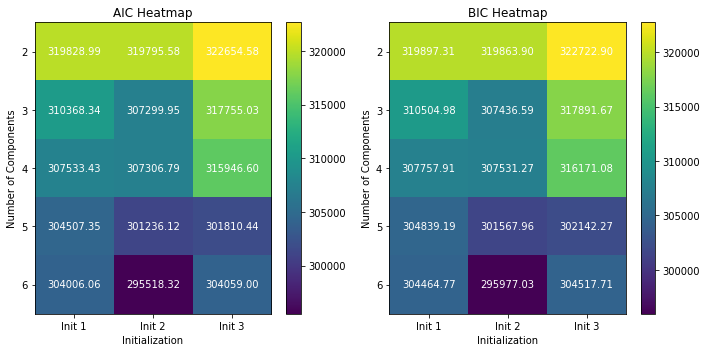

In [ ]:
# Generate heatmaps of AIC and BIC
import matplotlib.pyplot as plt
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
n_components_list = list(range(2, 7))
aic = np.array([[results[f'{n}_init_{i}']['aic'] for i in range(n_init)] for n in n_components_list])
bic = np.array([[results[f'{n}_init_{i}']['bic'] for i in range(n_init)] for n in n_components_list])

def plot_heatmap(data, ax, title):
    cax = ax.imshow(data, cmap='viridis', aspect='auto')
    ax.set_xticks(np.arange(n_init))
    ax.set_xticklabels([f'Init {i + 1}' for i in range(n_init)])
    ax.set_yticks(np.arange(len(n_components_list)))
    ax.set_yticklabels(n_components_list)
    ax.set_title(title)
    ax.set_xlabel('Initialization')
    ax.set_ylabel('Number of Components')
    # Annotate each cell with the value
    for i in range(data.shape[0]):
        for j in range(data.shape[1]):
            ax.text(j, i, f'{data[i, j]:.2f}', ha='center', va='center', color='white')
    plt.colorbar(cax, ax=ax)

plot_heatmap(aic, axs[0], 'AIC Heatmap')
plot_heatmap(bic, axs[1], 'BIC Heatmap')
plt.tight_layout()
plt.show()


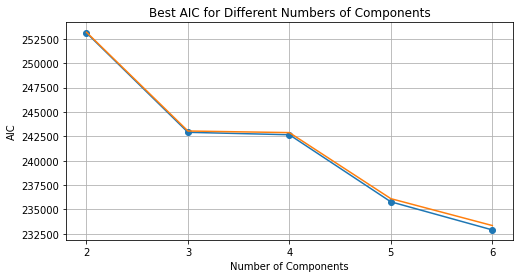

In [ ]:
plt.plot(aic.min(axis=1), 'o-', label='AIC Min per Components')
plt.plot(bic.min(axis=1), label='BIC Min per Components')
plt.xticks(range(len(n_components_list)), n_components_list)
plt.xlabel('Number of Components')
plt.ylabel('AIC')
plt.title('Best AIC for Different Numbers of Components')
plt.grid()
plt.gcf().set_size_inches(8, 4)
#plt.legend()

# Set dpi
#plt.savefig('best_aic_components.png', dpi=300, bbox_inches='tight')


plt.show()


In [ ]:
import pickle

#my_dict = {"key1": "value1", "key2": 2, "key3": [1, 2, 3]}
filename = "results2.pkl"

# Save the dictionary
with open(filename, 'wb') as file:
    pickle.dump(results, file)


In [ ]:
results['3_init_1']['model']


GaussianHMM(covariance_type='full', n_components=3, n_iter=30, random_state=127,
            verbose=True)

In [ ]:
from hmmlearn.hmm import GaussianHMM

# Create and fit the HMM model
# This was selected as the best model through cross-validation (see `modeling_stats.ipynb`).
model = GaussianHMM(n_components=3, covariance_type='full', n_iter=100, random_state=127, verbose=True)
model.fit(X_train, lengths=lengths_train)


/opt/anaconda3/lib/python3.9/site-packages/threadpoolctl.py:1214: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
         1 -151042.35489301             +nan
         2 -125185.25417201  +25857.10072100
         3 -123519.77532888   +1665.47884313
         4 -123135.21417405    +384.56115483
         5 -122970.80782245    +164.40635160
         6 -122869.24774065    +101.56008180
         7 -122798.37099742     +70.87674324
         8 -122746.51249112     +51.85850630
         9 -122707.68599914     +38.82649197
        10 -122678.20978343     +29.47621571
        11 -122655.60

GaussianHMM(covariance_type='full', n_components=3, n_iter=100,
            random_state=127, verbose=True)

In [ ]:
def compute_state_proportions(model, X, lengths):
    """
    Given a fitted HMM model, data X, and sequence lengths,
    returns an array of shape (n_samples, n_states) where each row
    contains the proportion of time spent in each state for a sample.
    """
    states = model.predict(X, lengths=lengths)
    n_states = model.n_components
    n_samples = len(lengths)
    proportions = np.zeros((n_samples, n_states))
    seq_starts = np.cumsum([0] + list(lengths[:-1]))
    seq_ends = np.cumsum(lengths)
    for i, (st, en) in enumerate(zip(seq_starts, seq_ends)):
        sample_states = states[st:en]
        for s in range(n_states):
            proportions[i, s] = np.mean(sample_states == s)
    return proportions


In [ ]:
import pandas as pd

# Helper to get start/end indices for each sequence in X_train
seq_starts = np.cumsum([0] + lengths_train)
seq_ends = np.cumsum(lengths_train)

states = model.predict(X_train, lengths=lengths_train)  # Predict states for the entire dataset
n_states = states.max() + 1  # number of unique states
n_samples = len(seq_starts) # = len(y_train)

# For each state, compute empirical mean/var for both features
means = []
vars_ = []
for s in range(n_states):
    mask = states == s
    means.append(X_train[mask].mean(axis=0))
    vars_.append(X_train[mask].var(axis=0))

means = np.array(means)
vars_ = np.array(vars_)



'''# For each sample, compute proportion of time spent in each state
proportions = np.zeros((n_samples, n_states))
for i in range(n_samples):
    st, en = seq_starts[i], seq_ends[i]
    sample_states = states[st:en]
    for s in range(n_states):
        proportions[i, s] = np.mean(sample_states == s)'''
# Compute state proportions for the training set
proportions = compute_state_proportions(model, X_train, lengths_train)

# Group indices
n_pd = y_train[y_train == 1].sum()  # Number of PD samples
pd_idx = np.arange(n_samples)[y_train == 1]
ctrl_hcp_idx = np.arange(n_samples)[y_train == 0]

# For each state, compute total proportion and percentiles for each group
rows = []
for s in range(n_states):
    # Empirical mean/var
    #mean0, mean1 = means[s, 0], means[s, 1]
    #var0, var1 = vars_[s, 0], vars_[s, 1]
    mean = means[s]
    var = vars_[s]
    # Proportion in each group
    prop_pd = proportions[pd_idx, s].sum() / n_pd
    prop_ctrl_hcp = proportions[ctrl_hcp_idx, s].sum() / (n_samples - n_pd)
    # Percentiles
    pct_pd = np.percentile(proportions[pd_idx, s], [5, 50, 95])
    pct_ctrl_hcp = np.percentile(proportions[ctrl_hcp_idx, s], [5, 50, 95])
    rows.append({
        "State": s,
        "Mean_RMSD": mean,
        "Var_RMSD": var,
        "Prop_Total_PD": prop_pd,
        "Prop_Total_CtrlHCP": prop_ctrl_hcp,
        "PD_5th": pct_pd[0],
        "PD_50th": pct_pd[1],
        "PD_95th": pct_pd[2],
        "CtrlHCP_5th": pct_ctrl_hcp[0],
        "CtrlHCP_50th": pct_ctrl_hcp[1],
        "CtrlHCP_95th": pct_ctrl_hcp[2],
    })

df_states = pd.DataFrame(rows)
pd.set_option('display.precision', 4)
display(df_states)


,State,Mean_RMSD,Var_RMSD,Prop_Total_PD,Prop_Total_CtrlHCP,PD_5th,PD_50th,PD_95th,CtrlHCP_5th,CtrlHCP_50th,CtrlHCP_95th
0,0,[0.04334427],[0.79437214],0.5319,0.7068,0.0752,0.500,0.9897,0.165,0.775,1.000
1,1,[2.5820253],[3.3449688],0.0504,0.0300,0.0100,0.045,0.1097,0.000,0.025,0.075
2,2,[-0.38304073],[0.15663056],0.4177,0.2632,0.0000,0.435,0.8642,0.000,0.185,0.815


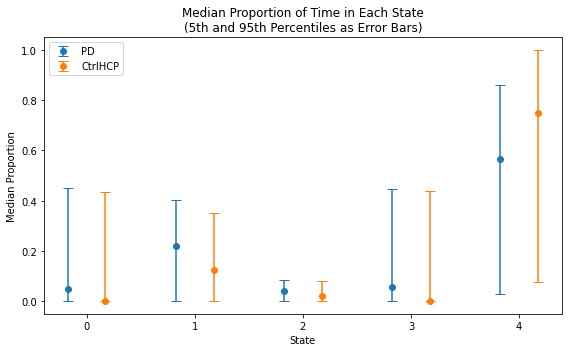

In [ ]:
# Boxplot of medians for PD and CtrlHCP with 5th and 95th percentiles as error bars
from matplotlib import pyplot as plt
fig, ax = plt.subplots(figsize=(8, 5))

# Extract medians and error bars from df_states
pd_medians = df_states["PD_50th"]
ctrlhcp_medians = df_states["CtrlHCP_50th"]

pd_err = np.vstack([
    pd_medians - df_states["PD_5th"],
    df_states["PD_95th"] - pd_medians
])
ctrlhcp_err = np.vstack([
    ctrlhcp_medians - df_states["CtrlHCP_5th"],
    df_states["CtrlHCP_95th"] - ctrlhcp_medians
])

positions = np.arange(len(df_states))
width = 0.35

ax.errorbar(
    positions - width/2, pd_medians, yerr=pd_err, fmt='o', label='PD', capsize=5
)
ax.errorbar(
    positions + width/2, ctrlhcp_medians, yerr=ctrlhcp_err, fmt='o', label='CtrlHCP', capsize=5
)

ax.set_xticks(positions)
ax.set_xticklabels(df_states["State"])
ax.set_xlabel("State")
ax.set_ylabel("Median Proportion")
ax.set_title("Median Proportion of Time in Each State\n(5th and 95th Percentiles as Error Bars)")
ax.legend()
plt.tight_layout()
plt.show()


In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

proportions = compute_state_proportions(model, X_train, lengths_train)
#prop_state4 = proportions[:, 4]  # Proportion in state 4

# Train a logistic regression model to predict group membership
C_grid = np.logspace(-30, 10, 100)  # Regularization strength grid

# Perform grid search to find the best regularization strength
# (High variance so not that reliable)
log_reg = GridSearchCV(
    LogisticRegression(max_iter=1000, random_state=RNG_SEED),
    param_grid={'C': C_grid},
    scoring='f1_macro',  # Use F1 score for evaluation
    cv=5,
    verbose=1
)

log_reg.fit(proportions, y_train)
# Best regularization strength
best_C = log_reg.best_params_['C']
print(f"Best regularization strength: {best_C}")
print(f"Best F1 score: {log_reg.best_score_:.4f}")
log_reg_best = log_reg.best_estimator_


Fitting 5 folds for each of 100 candidates, totalling 500 fits
Best regularization strength: 1353.0477745797964
Best F1 score: 0.6557


In [ ]:
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report
from sklearn.metrics import roc_auc_score, roc_curve

def predict_probs(hmm, log_reg, X, lengths):
    """
    Predicts logits for each sample in X using the fitted HMM model.
    Returns a tensor of shape (n_samples,) where each row contains the logits
    """
    proportions = compute_state_proportions(hmm, X, lengths)
    #prop_state4 = proportions[:, 4]  # Proportion in state 1
    return log_reg.predict_proba(proportions)[:, 1]  # Probability of being in PD group

def evaluate_model(hmm, log_reg, X, lengths, y_true,
                   threshold=0.5, print_report=True):
    """
    Evaluates the model on the given data.
    Returns accuracy, F1 score, confusion matrix, and classification report.
    """
    y_pred_probs = predict_probs(hmm, log_reg, X, lengths)
    y_pred = (y_pred_probs >= threshold).astype(int)

    accuracy = accuracy_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred, average='macro')
    cm = confusion_matrix(y_true, y_pred)
    if print_report:
        print(f"AUC Score: {roc_auc_score(y_true, y_pred_probs):.4f}")
        print("Classification Report:")
        print(classification_report(y_true, y_pred))
        print("Confusion Matrix:")
        print(cm)

    return y_pred_probs, accuracy, f1, cm


In [ ]:
# Training set evaluation
print("Evaluating on training set:")
y_pred_probs_train = evaluate_model(
    model, log_reg_best, X_train, lengths_train, y_train
)[0]

print('-' * 60)

# Test set evaluation
print("Evaluating on test set:")
y_pred_probs = evaluate_model(
    model, log_reg_best, X_val, lengths_val, y_val
)[0]


Evaluating on training set:
AUC Score: 0.7082
Classification Report:
              precision    recall  f1-score   support

         0.0       0.65      0.64      0.65       250
         1.0       0.66      0.67      0.67       262

    accuracy                           0.66       512
   macro avg       0.66      0.66      0.66       512
weighted avg       0.66      0.66      0.66       512

Confusion Matrix:
[[161  89]
 [ 86 176]]
------------------------------------------------------------
Evaluating on test set:
AUC Score: 0.6436
Classification Report:
              precision    recall  f1-score   support

         0.0       0.63      0.54      0.58        70
         1.0       0.53      0.62      0.57        58

    accuracy                           0.58       128
   macro avg       0.58      0.58      0.58       128
weighted avg       0.59      0.58      0.58       128

Confusion Matrix:
[[38 32]
 [22 36]]


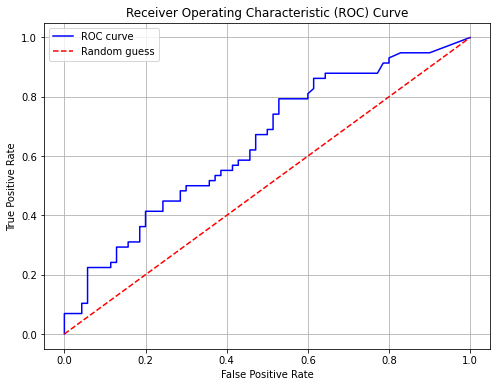

In [ ]:
# Plot ROC curve
import matplotlib.pyplot as plt
def plot_roc_curve(y_true, y_scores):
    fpr, tpr, _ = roc_curve(y_true, y_scores)
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='blue', label='ROC curve')
    plt.plot([0, 1], [0, 1], color='red', linestyle='--', label='Random guess')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend()
    plt.grid()
    plt.show()
# Plot ROC curve for test set
plot_roc_curve(y_val, y_pred_probs)


In [ ]:
y_pred = (y_pred_probs >= 0.5).astype(int)
print(f"Test set accuracy: {accuracy_score(y_val, y_pred):.4f}")
print(f"Test set F1 score: {f1_score(y_val, y_pred, average='macro'):.4f}")
print(f"Test set AUC: {roc_auc_score(y_val, y_pred_probs):.4f}")
#misclassified_keys = [k for i, k in enumerate(val_keys) if y_pred[i] != y_test[i]]

# Compute sensitivity and specificity
cm = confusion_matrix(y_val, y_pred)
sensitivity = cm[1, 1] / (cm[1, 1] + cm[1, 0]) if (cm[1, 1] + cm[1, 0]) > 0 else 0
specificity = cm[0, 0] / (cm[0, 0] + cm[0, 1]) if (cm[0, 0] + cm[0, 1]) > 0 else 0
print(f"Sensitivity: {sensitivity:.4f}")
print(f"Specificity: {specificity:.4f}")

# Compute proportion in PPMI vs HCP
#misclassified_keys_ppmi = [k for k in misclassified_keys if k in data_dict_ppmi]
#print(f"Proportion of misclassified keys in PPMI: {len(misclassified_keys_ppmi) / len(misclassified_keys):.2f}")
print(f"Proportion of overall keys in PPMI: {len(data_dict_ppmi) / (len(data_dict_ppmi) + len(data_dict_hcp)):.2f}")


Test set accuracy: 0.5781
Test set F1 score: 0.5780
Test set AUC: 0.6436
Sensitivity: 0.6207
Specificity: 0.5429
Proportion of overall keys in PPMI: 0.49
